# Batik Classification using CNN

## Directory check
For now I'm using `google.colab` which might take time during the training process because of the interaction between Colab and Drive. Instead, we can also use Jupyter Notebook itself.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [4]:
import os
for dirpath, dirnames, filenames in os.walk("data_klasifikasi_batik"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

There are 2 directories and 0 files in data_klasifikasi_batik
There are 6 directories and 0 files in data_klasifikasi_batik/test
There are 0 directories and 10 files in data_klasifikasi_batik/test/Lereng
There are 0 directories and 10 files in data_klasifikasi_batik/test/Nitik
There are 0 directories and 10 files in data_klasifikasi_batik/test/Parang
There are 0 directories and 10 files in data_klasifikasi_batik/test/Mix motif
There are 0 directories and 10 files in data_klasifikasi_batik/test/Ceplok
There are 0 directories and 10 files in data_klasifikasi_batik/test/Kawung
There are 6 directories and 0 files in data_klasifikasi_batik/train
There are 0 directories and 89 files in data_klasifikasi_batik/train/Kawung
There are 0 directories and 132 files in data_klasifikasi_batik/train/Ceplok
There are 0 directories and 165 files in data_klasifikasi_batik/train/Parang
There are 0 directories and 52 files in data_klasifikasi_batik/train/Lereng
There are 0 directories and 110 files in data

## Sample data check

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  # Take 1 sample
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Picture size: {img.shape}")
  return img

Picture size: (500, 500, 3)


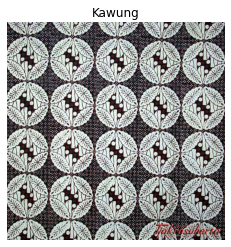

Picture size: (500, 500, 3)


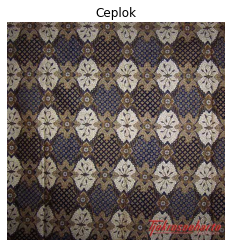

Picture size: (500, 500, 3)


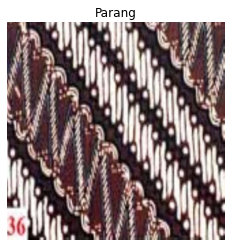

Picture size: (500, 500, 3)


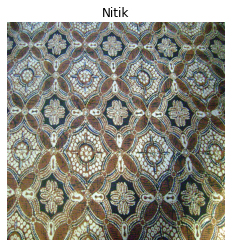

Picture size: (612, 792, 3)


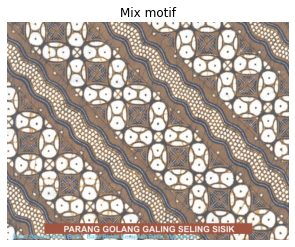

Picture size: (500, 500, 3)


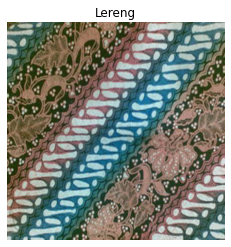

In [9]:
for cls in ["Kawung", "Ceplok", "Parang", "Nitik", "Mix motif", "Lereng"]:
  view_random_image("data_klasifikasi_batik/train/", cls)
  plt.show()

Note to self: Some pictures have different sizes like `(1200, 1200, 3)` although the majority size is `(500, 500, 3)`.

## Model building
Let's start by importing many things from Tensorflow and setting the random seed with any integer, for me is 3244 thanks to CS3244 ;)

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [11]:
tf.random.set_seed(3244)

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_dir = "data_klasifikasi_batik/train/"
test_dir = "data_klasifikasi_batik/test/"

In [14]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = 16,
                                               target_size = (500, 500),
                                               class_mode = "categorical",
                                               seed = 3244)

valid_data = train_datagen.flow_from_directory(test_dir,
                                               batch_size = 16,
                                               target_size = (500, 500),
                                               class_mode = "categorical",
                                               seed = 3244)

Found 580 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


### Model 1
Very simple, but also very prone to overfitting as seen in the loss and accuracy curve.

In [15]:
model_1 = Sequential([
                      Conv2D(10, 3, activation = 'relu'), # 10 filters, 3x3 kernel size
                      MaxPool2D(2),
                      Conv2D(10, 3, activation = 'relu'), # 10 filters, 3x3 kernel size
                      MaxPool2D(2),
                      Flatten(),
                      Dense(6, activation = 'softmax') # 6 classes
])

In [16]:
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

In [17]:
history_1 = model_1.fit(train_data,
                        epochs = 10, # probably try 30 to check overfit also
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/10
37/37 [==============================] - 131s 4s/step - loss: 5.6151 - accuracy: 0.2586 - val_loss: 1.8007 - val_accuracy: 0.3333
Epoch 2/10
37/37 [==============================] - 8s 226ms/step - loss: 1.4617 - accuracy: 0.5017 - val_loss: 1.7645 - val_accuracy: 0.3833
Epoch 3/10
37/37 [==============================] - 8s 224ms/step - loss: 1.0348 - accuracy: 0.6776 - val_loss: 1.6277 - val_accuracy: 0.3500
Epoch 4/10
37/37 [==============================] - 8s 226ms/step - loss: 0.7049 - accuracy: 0.7931 - val_loss: 2.1477 - val_accuracy: 0.3833
Epoch 5/10
37/37 [==============================] - 8s 228ms/step - loss: 0.5622 - accuracy: 0.8638 - val_loss: 2.4956 - val_accuracy: 0.2833
Epoch 6/10
37/37 [==============================] - 8s 225ms/step - loss: 0.4975 - accuracy: 0.8672 - val_loss: 2.5995 - val_accuracy: 0.3833
Epoch 7/10
37/37 [==============================] - 8s 225ms/step - loss: 0.3918 - accuracy: 0.9017 - val_loss: 2.5024 - val_accuracy: 0.3833
Epoch 8

In [18]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  
  plt.plot(epochs, loss, label = "Training loss")
  plt.plot(epochs, val_loss, label = "Validation loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = "Training accuracy")
  plt.plot(epochs, val_accuracy, label = "Validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

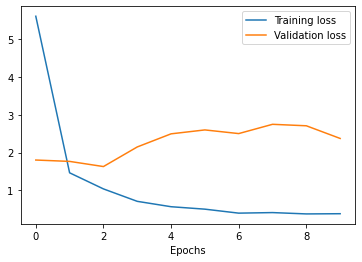

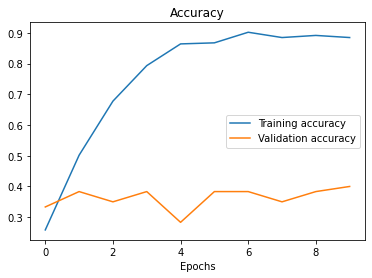

In [19]:
plot_loss_curves(history_1)

### Model 2: Data Augmentation
We'll see if data augmentation can reduce overfitting...

Note that data augmentation does not increase the number of our training data points, it just affects how the algorithm receives each data.

In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
train_data_augmented = train_datagen.flow_from_directory(train_dir,
                                                         batch_size = 16,
                                                         target_size = (500, 500),
                                                         class_mode = "categorical",
                                                         shuffle = True)

Found 580 images belonging to 6 classes.


This is just a copy fromm `model_1`.

In [22]:
model_2 = Sequential([
                      Conv2D(10, 3, activation = 'relu'), # 10 filters, 3x3 kernel size
                      MaxPool2D(2),
                      Conv2D(10, 3, activation = 'relu'), # 10 filters, 3x3 kernel size
                      MaxPool2D(2),
                      Flatten(),
                      Dense(6, activation = 'softmax') # 6 classes
])

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data_augmented,
                        epochs = 10, # probably try 30 to check overfit also
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/10
37/37 [==============================] - 37s 998ms/step - loss: 3.5007 - accuracy: 0.1845 - val_loss: 1.8861 - val_accuracy: 0.1500
Epoch 2/10
37/37 [==============================] - 36s 982ms/step - loss: 1.6964 - accuracy: 0.2672 - val_loss: 2.0130 - val_accuracy: 0.2500
Epoch 3/10
37/37 [==============================] - 37s 987ms/step - loss: 1.6692 - accuracy: 0.3259 - val_loss: 2.0755 - val_accuracy: 0.1667
Epoch 4/10
37/37 [==============================] - 37s 989ms/step - loss: 1.6398 - accuracy: 0.3414 - val_loss: 1.9734 - val_accuracy: 0.1833
Epoch 5/10
37/37 [==============================] - 36s 978ms/step - loss: 1.6076 - accuracy: 0.3552 - val_loss: 2.1331 - val_accuracy: 0.2667
Epoch 6/10
37/37 [==============================] - 36s 983ms/step - loss: 1.5869 - accuracy: 0.3862 - val_loss: 1.8305 - val_accuracy: 0.2500
Epoch 7/10
37/37 [==============================] - 37s 985ms/step - loss: 1.5516 - accuracy: 0.4069 - val_loss: 1.9008 - val_accuracy: 0.3333

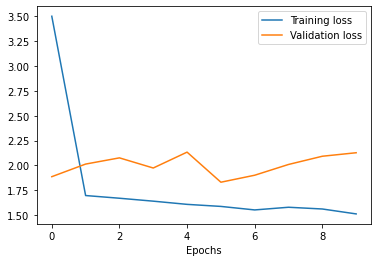

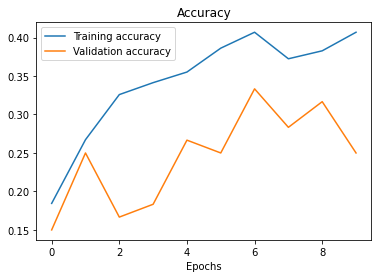

In [23]:
plot_loss_curves(history_2)

Seems better, but the accuracies are very low. Can we do better?

### Model 3: Increase batch size
Instead of 16, how about a batch size of 32? Probably the data will perform better due to the familiarity of its batch?

Note: OOM for 64, so had to decrease to 32 :')

In [29]:
train_data_augmented = train_datagen.flow_from_directory(train_dir,
                                                         batch_size = 32,
                                                         target_size = (500, 500),
                                                         class_mode = "categorical",
                                                         shuffle = True)

Found 580 images belonging to 6 classes.


Had a good talk about why ReLu is so much more used than sigmoid, including its variations like Leaky ReLu. One point is the derivative of the function which is mostly used during gradient descent or backpropagation.

In [30]:
model_3 = Sequential([
                      Conv2D(50, 3, activation = 'relu'),
                      Conv2D(50, 3, activation = 'relu'),
                      MaxPool2D(2),
                      Conv2D(50, 3, activation = 'relu'),
                      Conv2D(50, 3, activation = 'relu'),
                      MaxPool2D(2),
                      Flatten(),
                      Dense(6, activation = 'softmax') # 6 classes
])

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

# Remove steps because of data shortage, let the fitter decide
history_3 = model_3.fit(train_data_augmented,
                        epochs = 10,
                        validation_data = valid_data)

Epoch 1/10
19/19 [==============================] - 72s 4s/step - loss: 3.9474 - accuracy: 0.2241 - val_loss: 1.8094 - val_accuracy: 0.1667
Epoch 2/10
19/19 [==============================] - 49s 3s/step - loss: 1.7237 - accuracy: 0.2655 - val_loss: 1.9156 - val_accuracy: 0.3167
Epoch 3/10
19/19 [==============================] - 49s 3s/step - loss: 1.6727 - accuracy: 0.3190 - val_loss: 2.1240 - val_accuracy: 0.3000
Epoch 4/10
19/19 [==============================] - 49s 3s/step - loss: 1.6696 - accuracy: 0.3034 - val_loss: 1.7704 - val_accuracy: 0.2000
Epoch 5/10
19/19 [==============================] - 49s 3s/step - loss: 1.6846 - accuracy: 0.3276 - val_loss: 1.8158 - val_accuracy: 0.2000
Epoch 6/10
19/19 [==============================] - 49s 3s/step - loss: 1.6280 - accuracy: 0.3293 - val_loss: 1.8032 - val_accuracy: 0.2500
Epoch 7/10
19/19 [==============================] - 50s 3s/step - loss: 1.6050 - accuracy: 0.3534 - val_loss: 1.8124 - val_accuracy: 0.2333
Epoch 8/10
19/19 [==

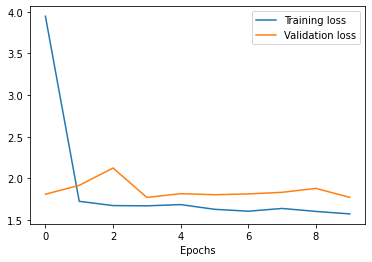

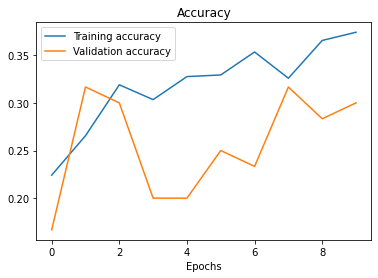

In [31]:
plot_loss_curves(history_3)

### Model 4: Using MobileNetV2
Hearsay it's better than the plain CNN in general. Although we don't have that many data, hopefully it does better than Model 3.

In [32]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = (450, 450, 3),
                                                            include_top = False,
                                                            weights = "imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [33]:
base_model.trainable = False

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = Dense(6)
soft = Activation('softmax')

inputs = tf.keras.Input(shape = (450, 450, 3))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
outputs = soft(outputs)

model_4 = tf.keras.Model(inputs, outputs)
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_4 = model_4.fit(train_data_augmented,
                        epochs = 10,
                        validation_data = valid_data)

Epoch 1/10
19/19 [==============================] - 45s 2s/step - loss: 1.5873 - accuracy: 0.3724 - val_loss: 1.8368 - val_accuracy: 0.3833
Epoch 2/10
19/19 [==============================] - 38s 2s/step - loss: 1.3118 - accuracy: 0.5259 - val_loss: 1.4464 - val_accuracy: 0.3833
Epoch 3/10
19/19 [==============================] - 38s 2s/step - loss: 1.1755 - accuracy: 0.5862 - val_loss: 1.5672 - val_accuracy: 0.4000
Epoch 4/10
19/19 [==============================] - 39s 2s/step - loss: 1.0929 - accuracy: 0.6207 - val_loss: 1.4493 - val_accuracy: 0.3833
Epoch 5/10
19/19 [==============================] - 40s 2s/step - loss: 1.0339 - accuracy: 0.6155 - val_loss: 1.4328 - val_accuracy: 0.4000
Epoch 6/10
19/19 [==============================] - 39s 2s/step - loss: 0.9794 - accuracy: 0.6328 - val_loss: 1.4814 - val_accuracy: 0.3833
Epoch 7/10
19/19 [==============================] - 39s 2s/step - loss: 0.9547 - accuracy: 0.6276 - val_loss: 1.4663 - val_accuracy: 0.4000
Epoch 8/10
19/19 [==

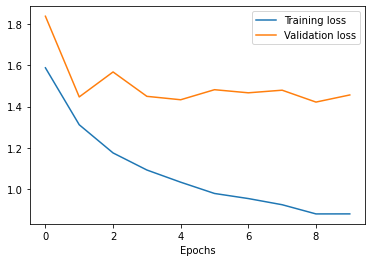

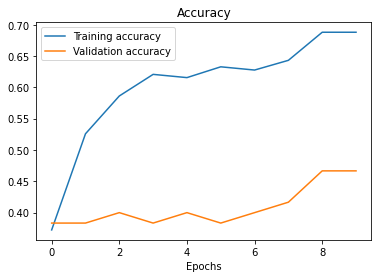

In [35]:
plot_loss_curves(history_4)

It is indeed better than `model_3` and has less spikes on the plot. And yes, that was the end of the livestream :)

This are just simple models, and therefore do not perform that good compared to the other models out there.